In [ ]:
  import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [ ]:
sdir = '/content/drive/MyDrive/XrayKneeOsteoarthritis'
image_size = (224, 224)
batch_size = 32
k_folds = 5

In [ ]:
filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
1  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
2  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
3  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
4  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
labels
0    3798
2    2545
4    1790
1    1749
3    1281
Name: count, dtype: int64


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['labels'], random_state=42)

print(train_df['labels'].value_counts())
print(test_df['labels'].value_counts())

labels
0    3418
2    2290
4    1611
1    1574
3    1153
Name: count, dtype: int64
labels
0    380
2    255
4    179
1    175
3    128
Name: count, dtype: int64


In [ ]:
datagen = ImageDataGenerator(
  rescale=1.0/255,
  horizontal_flip = True,
  )

valid_generator = ImageDataGenerator(
    rescale = 1./255
)

test_generator = ImageDataGenerator(
    rescale = 1./255
)

test_gen = test_generator.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=image_size,
    batch_size=batch_size, class_mode='categorical', shuffle = True
)

print("Preprocessing dataset selesai.")

Found 1117 validated image filenames belonging to 5 classes.
Preprocessing dataset selesai.


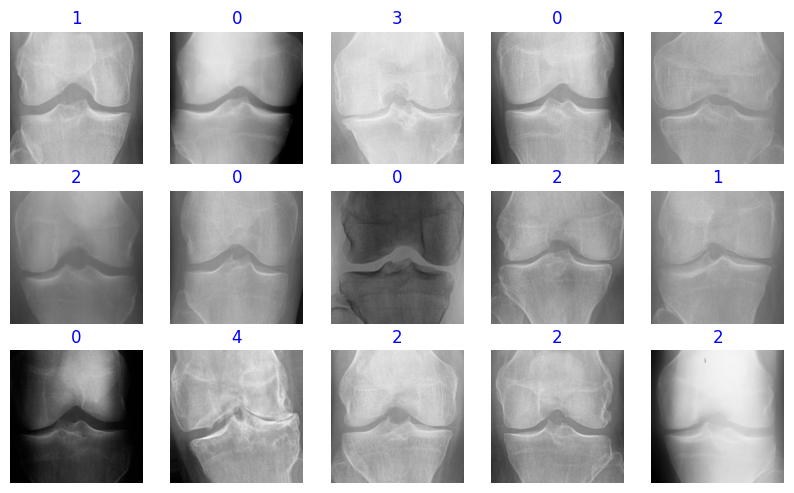

In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(10, 10))
    length=len(labels)
    if length<15:   #show maximum of 25 images
        r=length
    else:
        r=15
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

show_image_samples(test_gen)

In [ ]:
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

def create_model():
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze semua layer kecuali 4 terakhir
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    x = base_model.output

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

fold_accuracies = []
histories = []
fold = 1

for train_index, val_index in kf.split(train_df, train_df['labels']):
    print(f'\nTraining Fold {fold}...')

    fold_train_df = train_df.iloc[train_index].reset_index(drop = True)
    fold_valid_df = train_df.iloc[val_index].reset_index(drop = True)

    classes = np.unique(fold_train_df['labels'])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_train_df['labels'])
    class_weight_dict = dict(zip(classes, class_weights))
    print(f"Class weights (Fold {fold}):", class_weight_dict)

    train_gen = datagen.flow_from_dataframe(
        fold_train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_gen = valid_generator.flow_from_dataframe(
        fold_valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stopping, reduce_lr]
    )

    histories.append(history)

    scores = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold} - Loss: {scores[0]} - Accuracy: {scores[1]*100:.2f}%")

    fold_accuracies.append(scores[1] * 100)
    fold += 1

print('=================================')
print(f'Average accuracy over {k_folds} folds: {np.mean(fold_accuracies):.2f}% (+/- {np.std(fold_accuracies):.2f})')
print('=================================')



Training Fold 1...
Class weights (Fold 1): {'0': np.float64(0.5878566203365033), '1': np.float64(1.2765687053216839), '2': np.float64(0.877292576419214), '3': np.float64(1.7431670281995661), '4': np.float64(1.2468580294802172)}
Found 8036 validated image filenames belonging to 5 classes.
Found 2010 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1763s 7s/step - accuracy: 0.3666 - loss: 1.5074 - val_accuracy: 0.3418 - val_loss: 1.5881 - learning_rate: 1.0000e-04
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 78s 310ms/step - accuracy: 0.5392 - loss: 1.0537 - val_accuracy: 0.6219 - val_loss: 0.8951 - learning_rate: 1.0000e-04
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 307ms/step - accuracy: 0.6069 - loss: 0.9179 - val_accuracy: 0.6254 - val_loss: 0.8653 - learning_rate: 1.0000e-04
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 83s 312ms/step - accuracy: 0.6605 - loss: 0.8318 - val_accuracy: 0.6721 - val_loss: 0.7549 - learning_rate: 1.0000e-04
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 89s 342ms/step - accuracy: 0.6790 - loss: 0.7857 - val_accuracy: 0.6104 - val_loss: 0.8822 - learning_rate: 1.0000e-04
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 78s 309ms/step - accuracy: 0.6782 - loss: 0.7713 - val_accuracy: 0.6831 - val_loss: 0.7957 - learning_rate: 1.0000e-04
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 79s 312

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 106s 383ms/step - accuracy: 0.3575 - loss: 1.5459 - val_accuracy: 0.5316 - val_loss: 1.1702 - learning_rate: 1.0000e-04
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 305ms/step - accuracy: 0.5281 - loss: 1.0886 - val_accuracy: 0.5406 - val_loss: 1.0539 - learning_rate: 1.0000e-04
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 86s 341ms/step - accuracy: 0.6062 - loss: 0.9382 - val_accuracy: 0.6446 - val_loss: 0.8538 - learning_rate: 1.0000e-04
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 306ms/step - accuracy: 0.6324 - loss: 0.8491 - val_accuracy: 0.6312 - val_loss: 0.8422 - learning_rate: 1.0000e-04
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 306ms/step - accuracy: 0.6502 - loss: 0.8242 - val_accuracy: 0.6565 - val_loss: 0.8429 - learning_rate: 1.0000e-04
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 304ms/step - accuracy: 0.6883 - loss: 0.7598 - val_accuracy: 0.5938 - val_loss: 0.9776 - learning_rate: 1.0000e-04
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 82s 3

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 92s 329ms/step - accuracy: 0.3888 - loss: 1.4527 - val_accuracy: 0.2952 - val_loss: 1.8343 - learning_rate: 1.0000e-04
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 305ms/step - accuracy: 0.5342 - loss: 1.0760 - val_accuracy: 0.4211 - val_loss: 1.6140 - learning_rate: 1.0000e-04
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 305ms/step - accuracy: 0.6036 - loss: 0.9248 - val_accuracy: 0.5595 - val_loss: 0.9790 - learning_rate: 1.0000e-04
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 304ms/step - accuracy: 0.6522 - loss: 0.8307 - val_accuracy: 0.6755 - val_loss: 0.8046 - learning_rate: 1.0000e-04
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 82s 305ms/step - accuracy: 0.6794 - loss: 0.7857 - val_accuracy: 0.6137 - val_loss: 0.9192 - learning_rate: 1.0000e-04
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 303ms/step - accuracy: 0.6775 - loss: 0.7583 - val_accuracy: 0.6068 - val_loss: 1.0051 - learning_rate: 1.0000e-04
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 30

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 97s 356ms/step - accuracy: 0.3434 - loss: 1.5234 - val_accuracy: 0.2499 - val_loss: 1.8063 - learning_rate: 1.0000e-04
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 303ms/step - accuracy: 0.5612 - loss: 1.0349 - val_accuracy: 0.5072 - val_loss: 1.6466 - learning_rate: 1.0000e-04
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 76s 302ms/step - accuracy: 0.6186 - loss: 0.9110 - val_accuracy: 0.5993 - val_loss: 0.9302 - learning_rate: 1.0000e-04
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 86s 340ms/step - accuracy: 0.6480 - loss: 0.8461 - val_accuracy: 0.6396 - val_loss: 0.8432 - learning_rate: 1.0000e-04
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 304ms/step - accuracy: 0.6583 - loss: 0.8092 - val_accuracy: 0.5465 - val_loss: 1.0974 - learning_rate: 1.0000e-04
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 86s 341ms/step - accuracy: 0.6848 - loss: 0.7657 - val_accuracy: 0.6620 - val_loss: 0.7839 - learning_rate: 1.0000e-04
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 30

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 90s 325ms/step - accuracy: 0.3491 - loss: 1.5471 - val_accuracy: 0.4176 - val_loss: 1.9823 - learning_rate: 1.0000e-04
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 304ms/step - accuracy: 0.5189 - loss: 1.1147 - val_accuracy: 0.3858 - val_loss: 1.2995 - learning_rate: 1.0000e-04
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 86s 341ms/step - accuracy: 0.5840 - loss: 0.9761 - val_accuracy: 0.4604 - val_loss: 1.5096 - learning_rate: 1.0000e-04
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 305ms/step - accuracy: 0.6170 - loss: 0.9067 - val_accuracy: 0.5933 - val_loss: 0.9648 - learning_rate: 1.0000e-04
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 304ms/step - accuracy: 0.6504 - loss: 0.8370 - val_accuracy: 0.5431 - val_loss: 1.3852 - learning_rate: 1.0000e-04
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 86s 341ms/step - accuracy: 0.6555 - loss: 0.8188 - val_accuracy: 0.6580 - val_loss: 0.8251 - learning_rate: 1.0000e-04
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 30

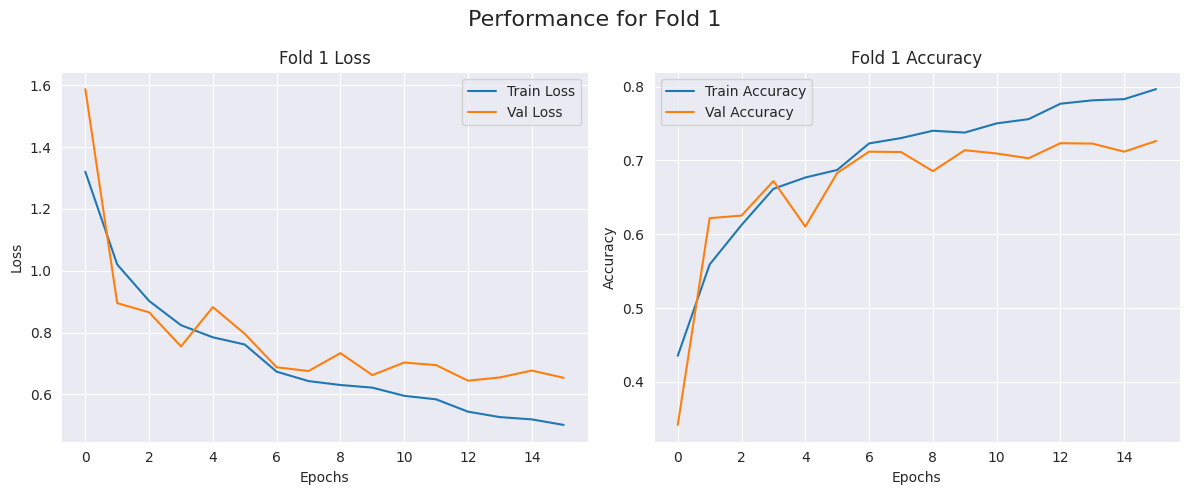

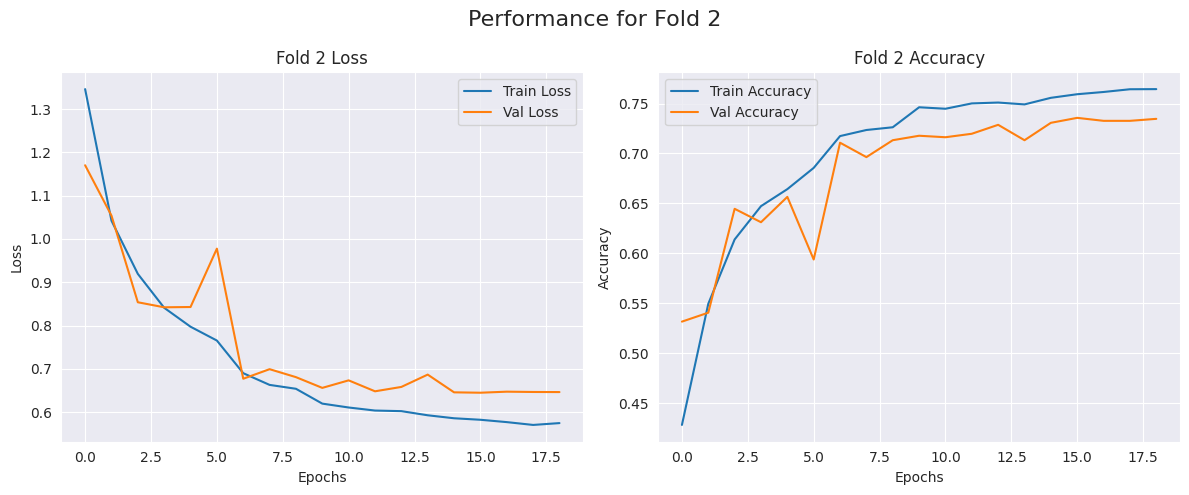

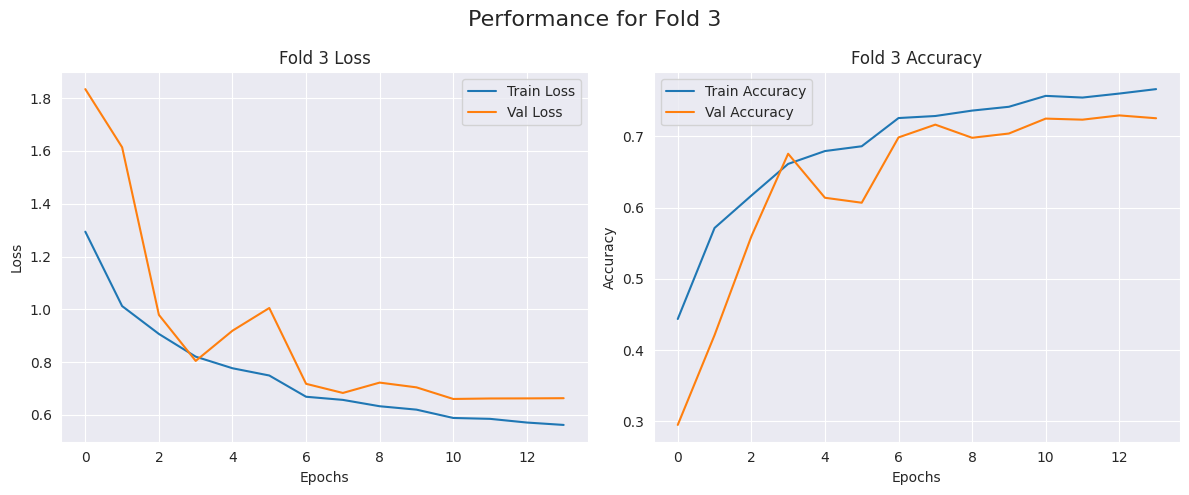

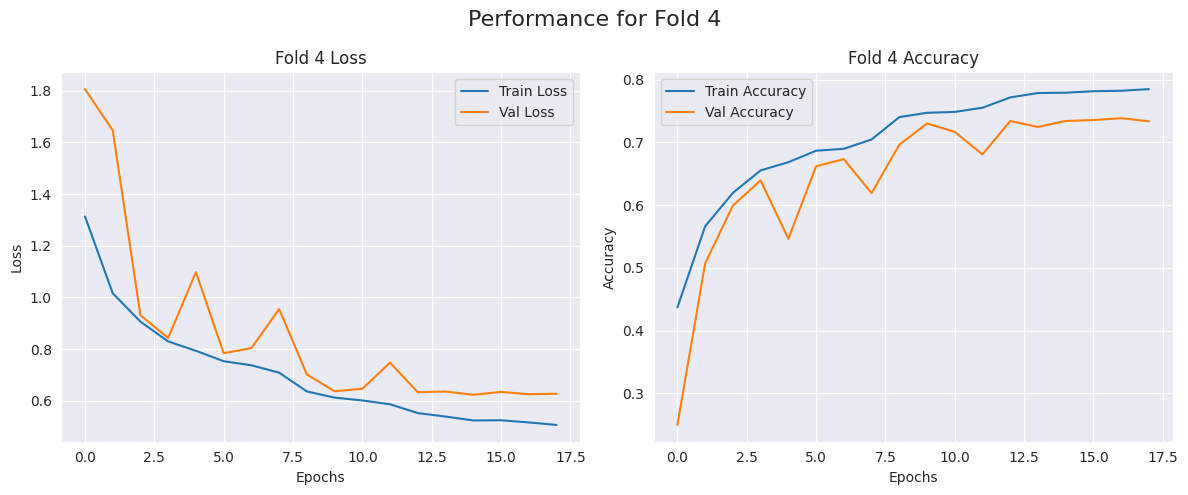

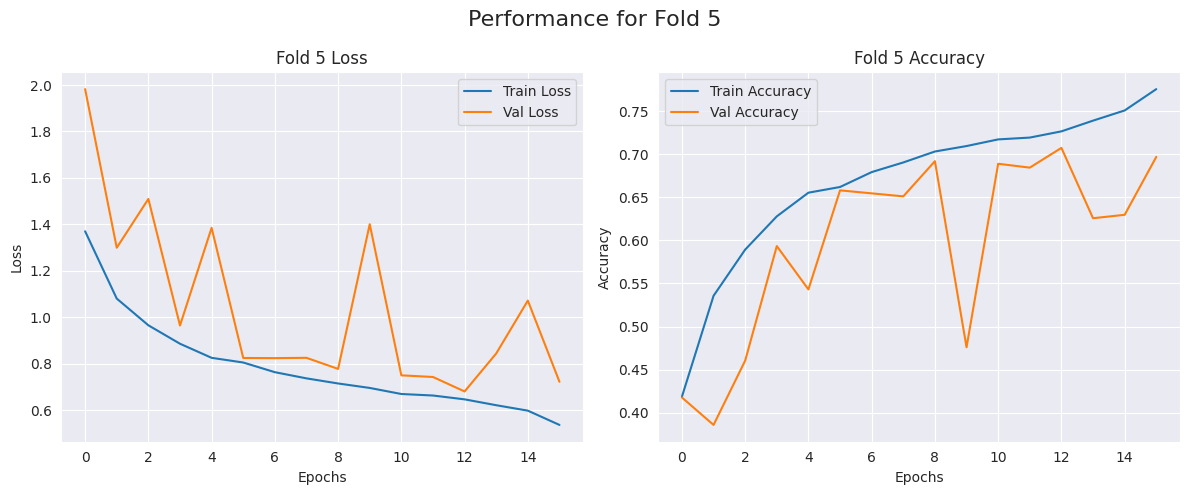

Semua plot selesai!


In [ ]:
for i, history in enumerate(histories, start=1):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(f'Performance for Fold {i}', fontsize=16)
    plt.tight_layout()
    plt.show()  # tampilkan plot fold i

print("Semua plot selesai!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

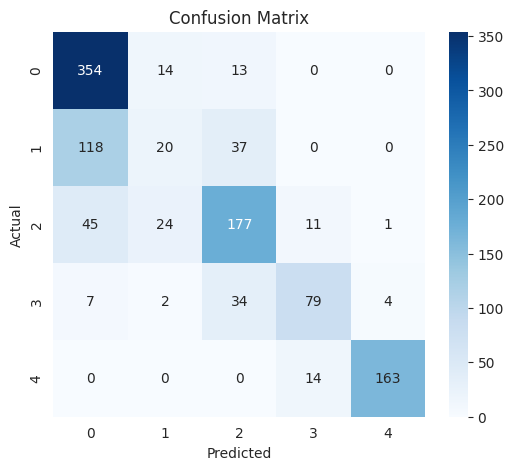

              precision    recall  f1-score   support

           0       0.68      0.93      0.78       381
           1       0.33      0.11      0.17       175
           2       0.68      0.69      0.68       258
           3       0.76      0.63      0.69       126
           4       0.97      0.92      0.94       177

    accuracy                           0.71      1117
   macro avg       0.68      0.66      0.65      1117
weighted avg       0.68      0.71      0.68      1117



In [ ]:
y_true = []
y_pred = []
class_labels = list(test_gen.class_indices.keys())

for _ in range(len(test_gen)):
    x_batch, y_batch = next(test_gen)
    y_true.extend(np.argmax(y_batch, axis=1))  # Label asli
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))  # Prediksi model

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
model.save('/content/drive/MyDrive/my_model.h5')